# ПРОЕКТ ТЕЛЕКОМ

# Описание проекта
Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# План работ
1. Исследовательский анализ данных (в данном этапе проведем анализ, выделим целевой признак, выведем релевантный график и отчет)
2. Объединение таблиц и проверка данных (заджойним таблицы и посмотрим пропуски или другую информацю, которая вылезет в последствии, исправим и сделаем анализ корреляции признаков)
3. Обучение моделей LightGBM и Random Forest (энкодинг категоральных признаков, разделение на выборки, обучение моделей и тюнинг параметров по метрике AUC-ROC)
4. Проверка лучшей модели на тестовой выборке 
5. Вывод


## Исследовательский анализ данных
Сперва импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import shuffle
import lightgbm as lgb

In [2]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [3]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

Наш датасет состоит из четырех таблиц. Сначала осмотрим каждую отдельно. 

In [4]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
contract.head() # 5 верхних строк

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
contract.info() # информация о файле

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


В первой таблице присутствует основная информация о клиентах  Нам нужно определить целевой признак, но его здесь нет. Сделаем его сами. Сперва нужно изменить тип данных у столбцов, чтобы он совпадал с хранящейся там информацией, затем по столбцуц EndDate выведем целевой признак. Если даты окончания договора нет, то клиента обозначим цифрой 1 (является абонентом), если будет дата - обозначим 0 (ушел). Паралельно изменим типы данных у других столбцов для анализа.  

In [6]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format = '%Y-%m-%d')
contract['EndDate'].loc[contract['EndDate'] == 'No'] = '2020-02-01'
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format = '%Y-%m-%d')
contract['still_here'] = 0
contract['still_here'].loc[contract['EndDate'] == '2020-02-01'] = 1

In [7]:
x = contract['still_here'].value_counts()
x

1    5174
0    1869
Name: still_here, dtype: int64

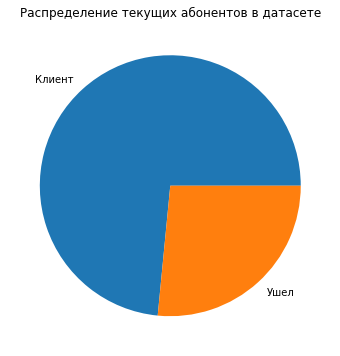

In [8]:
fig = plt.figure()
fig.set_figwidth(6)
fig.set_figheight(6)
plt.pie(x, labels=['Клиент', 'Ушел'])
plt.title('Распределение текущих абонентов в датасете')
plt.show()

По графику видим, что в данных присутствует дисбаланс. В целевом признаке четверть данных о клиентах, которые ушли, а 3/4 являются абонентами. \
Добавим еще один признак: кол-во дней, в течение которого клиент являлся абонентом. Нарисуем гистограмму и рассмотрим поближе. 

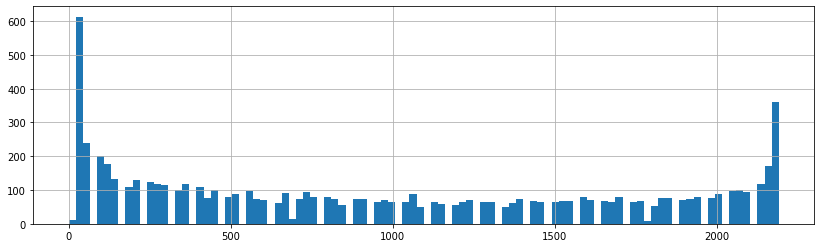

In [9]:
contract['loyalty'] = contract['EndDate'] - contract['BeginDate']
contract['loyalty'].astype(int)
contract['loyalty'] = contract['loyalty'] / np.timedelta64(1, 'D')
contract['loyalty'].hist(figsize=(14,4), bins=100);

In [10]:
contract['loyalty'].describe()

count   7,043.00
mean      986.00
std       747.59
min         0.00
25%       273.00
50%       883.00
75%     1,676.00
max     2,191.00
Name: loyalty, dtype: float64

На графике видим два пика: первый пик в самом начале показывает тех, кто долго не пробыл абонентом, второй пик в самом конце гистрограммы показывает текущих клиентов. Между двумя пиками видим что отток клиентов примерно одинаковый независимо от кол-ва дней. Проверим данные на аномалии. 

In [11]:
contract[contract['loyalty'] == 0]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,still_here,loyalty
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,1,0.00
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,1,0.00
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,1,0.00
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,1,0.00
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,1,0.00
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,1,0.00
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,1,0.00
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,1,0.00
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,1,0.00
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,1,0.00


In [12]:
contract.loc[contract['TotalCharges'] == '']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,still_here,loyalty


В данных есть 11 клиентов со странными датами начала и окончания (в один день) и пустой суммой по счетам. Так как их всего 11, эти аномалии мы удалим и поменяем тип данных у колонки TotalCharges.

In [13]:
contract.loc[contract['TotalCharges'] == ' '] = None
contract['TotalCharges'] = contract['TotalCharges'].dropna()
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   still_here        7032 non-null   float64       
 9   loyalty           7032 non-null   float64       
dtypes: datetime64[ns](2), float64(4), object(4)
memory usage: 550.4+ KB


Видим что значения в таблице исправлены, перейдем к следующим. 

In [14]:
personal = pd.read_csv('/datasets/final_provider/personal.csv')
personal.head() # 5 верхних строк

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [15]:
personal.info() # информация о файле

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [16]:
internet = pd.read_csv('/datasets/final_provider/internet.csv')
internet.head() # 5 верхних строк

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [17]:
internet.info() # информация о файле

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [18]:
phone = pd.read_csv('/datasets/final_provider/phone.csv')
phone.head() # 5 верхних строк

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [19]:
phone.info() # информация о файле

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В таблицах пропусик отсутствуют, в них содержатся только категоральные значения. Для обучения модели необходимо будет кодировать эти значения. Теперь можем перейти к следующему этапу: обьединению таблиц и анализу корреляции. 

## Обьединение таблиц и анализ кореляции

Сперва объединим таблицы и проверим, не появилось ли проблем

In [20]:
data = contract.merge(personal, how='outer')
data = data.merge(internet, how='outer')
data = data.merge(phone, how='outer')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7054 entries, 0 to 7053
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   still_here        7032 non-null   float64       
 9   loyalty           7032 non-null   float64       
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   float64       
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 n

После объединения видим, что прибавились иные пользователи, и те, которых мы могли удалить в предыдущей части. Так как у данных строк у нас нет возможноси выявить целевой признак и их всего 22, можем их удалить.\
Для правильного обучения удалим ненужные признаки: даты и имена клиентов, они нам не нужны.\
После удаления еще возникает вопрос с последними присоединенными таблицами: internet и phone. По ним видим, что не все пользователи испольщуют интернет услуги или телефонные услуги, поэтому информация об этом в таблице отсутствует. Заменим данные в таблице на новую категорию.

In [21]:
data = data.dropna(subset=['still_here'])
no_list = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
data[no_list] = data[no_list].fillna('No')
data = data.fillna('no info')
data = data.drop(labels=['customerID', 'BeginDate', 'EndDate'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   still_here        7032 non-null   float64
 6   loyalty           7032 non-null   float64
 7   gender            7032 non-null   object 
 8   SeniorCitizen     7032 non-null   float64
 9   Partner           7032 non-null   object 
 10  Dependents        7032 non-null   object 
 11  InternetService   7032 non-null   object 
 12  OnlineSecurity    7032 non-null   object 
 13  OnlineBackup      7032 non-null   object 
 14  DeviceProtection  7032 non-null   object 
 15  TechSupport       7032 non-null   object 
 16  StreamingTV       7032 non-null   object 


In [22]:
data

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,still_here,loyalty,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,Month-to-month,Yes,Electronic check,29.85,29.85,1.00,31.00,Female,0.00,Yes,No,DSL,No,Yes,No,No,No,No,no info
1,One year,No,Mailed check,56.95,"1,889.50",1.00,"1,036.00",Male,0.00,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,108.15,0.00,61.00,Male,0.00,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),42.30,"1,840.75",1.00,"1,371.00",Male,0.00,No,No,DSL,Yes,No,Yes,Yes,No,No,no info
4,Month-to-month,Yes,Electronic check,70.70,151.65,0.00,61.00,Female,0.00,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,Yes,Mailed check,84.80,"1,990.50",1.00,730.00,Male,0.00,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,One year,Yes,Credit card (automatic),103.20,"7,362.90",1.00,"2,191.00",Female,0.00,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,Month-to-month,Yes,Electronic check,29.60,346.45,1.00,337.00,Female,0.00,Yes,Yes,DSL,Yes,No,No,No,No,No,no info
7041,Month-to-month,Yes,Mailed check,74.40,306.60,0.00,123.00,Male,1.00,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


Убрав пропуски приступим к анализу корреляции. Используем фи-корреляцию для анализа. 

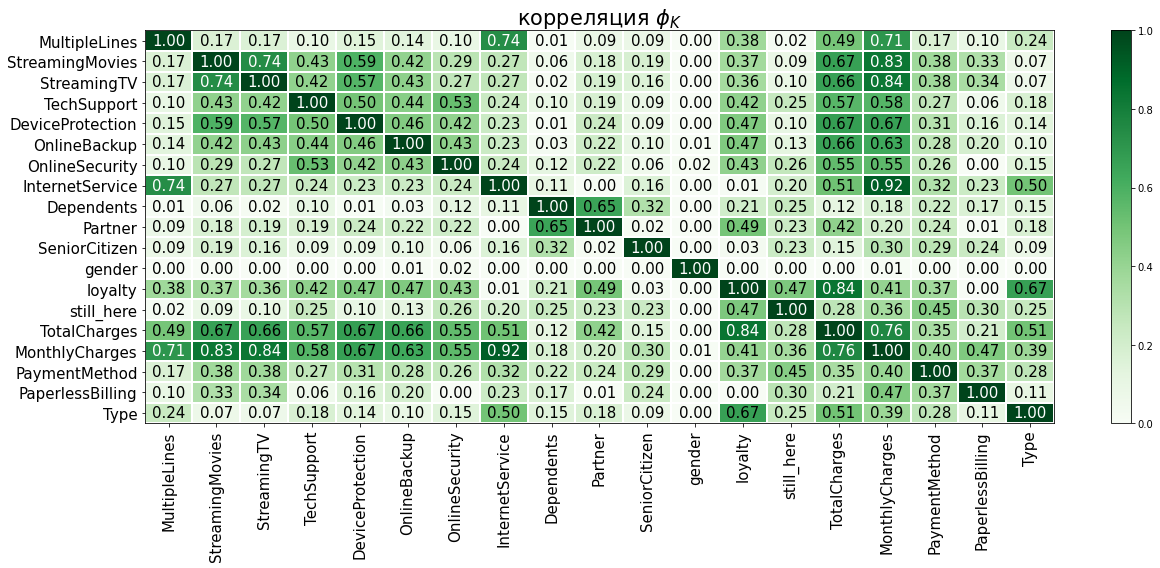

In [23]:
inter_col = ['MonthlyCharges', 'TotalCharges', 'still_here', 'loyalty']
phik_matrix = data.phik_matrix(interval_cols=inter_col)
plot_correlation_matrix(phik_matrix.values, 
                        x_labels=phik_matrix.columns, 
                        y_labels=phik_matrix.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"корреляция $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(18, 8))
plt.tight_layout()

В нашем датафрейме видим, что сильную корреляцию имеют признаки, связанные с суммой платежей (monthly и total), так же признаки по интернету и телефону видно коррелируют друг с другом. В первом случае логично, чем больше услуг подключено, тем больше платит абонент. Во втором корреляцию можно связать с тем, что при покупки одной функции, человек скорее легче готов приобретать еще сверху, либо они продаются комплектами.\
Нам важно рассмотреть, как другие признаки взаимодействуют с целевым признаком. Видимая корреляция для признака still_here с paymentMethod, monthlyCharges и loyalty. Остальные признаки слабо коррелируют с ним.\
С числовми признаками тоже видим сильную корреляцию между ещемесячными платежами и всего. Очевидно, что чем больше ежемесячные траты, тем выше общий чек. Так же сильная связь между loyalty и totalCharges. данную связь тоже легко обьясняется тем, что со временем средний чек увеличивается.

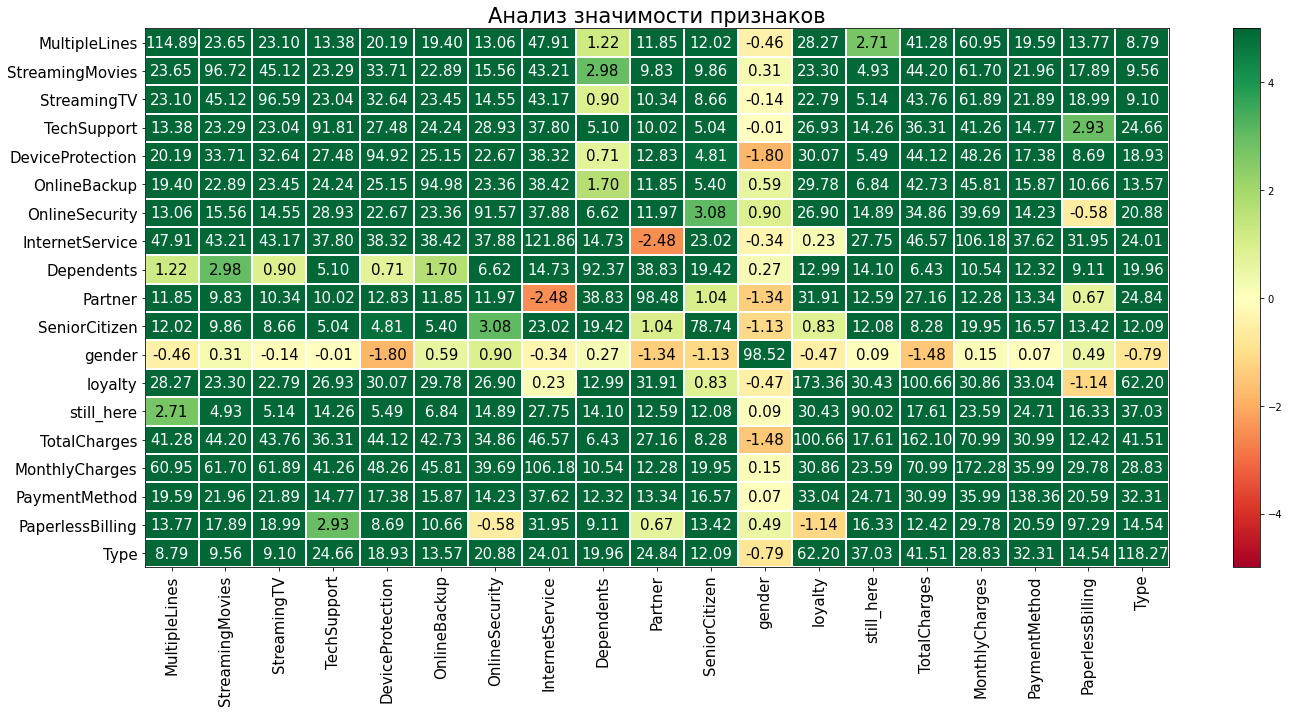

In [44]:
significance_overview = data.significance_matrix(interval_cols=inter_col)
plot_correlation_matrix(significance_overview.fillna(0).values,
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5,
                        title="Анализ значимости признаков", 
                        usetex=False, fontsize_factor=1.5, figsize=(20, 10))
plt.tight_layout()

"Плохие" признаки - 'gender', 'Dependents', 'PaperlessBilling', 'Partner', 'SeniorSitizen'

Далее перейдем к делению на выборки и кодированию. Деление будет на тренировочную и тестовую в пропорции 75:25

In [29]:
data_train, data_test = train_test_split(data, 
                                         test_size=0.25, 
                                         random_state=171022)
features_train = data_train.drop(['still_here'], axis=1)
target_train = data_train['still_here']
features_test = data_test.drop(['still_here'], axis=1)
target_test = data_test['still_here']
print(features_train.shape, features_test.shape)

(5274, 18) (1758, 18)


Видим что признаки разделились правильно.  Закодируем категоральные признаки и посмотрим на результат. Так как в нашем проекте не будут использоваться линейные модели, воспользуемся OrdinalEncoder

In [30]:
categorical_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 
                       'gender', 'SeniorCitizen','Partner', 'Dependents', 
                       'InternetService', 'OnlineSecurity','OnlineBackup', 
                       'DeviceProtection', 'TechSupport', 'StreamingTV',
                       'StreamingMovies', 'MultipleLines']

In [31]:
enc = OrdinalEncoder()
enc.fit(features_train[categorical_columns])

OrdinalEncoder()

In [32]:
features_train[categorical_columns] = enc.transform(features_train[categorical_columns])
features_test[categorical_columns] = enc.transform(features_test[categorical_columns])

Признаки закодированы, выборки готовы, можно переходить к следующему этапу проекта. 

## Обучение моделей

Начнем с обучения моделей. Нашей основной метрикой будет AUC-ROC. По ней будем определять лучшуу модель при помощи кросс-валидации. Первая водеть будет случайный лес. Признаки для модели будем подбирать с помощью RandomizedSearchCV.

In [33]:
%%time
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 250)] 
max_depth = [int(x) for x in np.linspace(1, 10)]
rf_grid = {'n_estimators': n_estimators, 'max_depth': max_depth}
model_rfc = RandomizedSearchCV(RandomForestClassifier(random_state=171022, class_weight='balanced'), 
                               rf_grid, scoring = 'roc_auc', 
                               cv=5)
model_rfc.fit(features_train, target_train)

CPU times: user 20.7 s, sys: 68 ms, total: 20.8 s
Wall time: 20.8 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=171022),
                   param_distributions={'max_depth': [1, 1, 1, 1, 1, 1, 2, 2, 2,
                                                      2, 2, 3, 3, 3, 3, 3, 3, 4,
                                                      4, 4, 4, 4, 5, 5, 5, 5, 5,
                                                      5, 6, 6, ...],
                                        'n_estimators': [100, 103, 106, 109,
                                                         112, 115, 118, 121,
                                                         124, 127, 130, 133,
                                                         136, 139, 142, 145,
                                                         148, 152, 155, 158,
                                                         161, 164, 167, 170,
                                                  

In [34]:
model_rfc.best_params_

{'n_estimators': 121, 'max_depth': 9}

In [35]:
model_rfc.best_score_

0.8628704324657678

При кросс-валидации получили auc-roc 0.85. Попробуем теперь LightGBM

In [36]:
%%time
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 150)]
num_leaves = [int(x) for x in np.linspace(start = 1, stop = 40)]
lgb_grid = {'n_estimators': n_estimators,
           'num_leaves':num_leaves}
lgb_rs_model = RandomizedSearchCV(estimator = lgb.LGBMClassifier(random_state=171022, class_weight='balanced'),
                                  param_distributions = lgb_grid, cv = 5, scoring = 'roc_auc')
lgb_rs_model.fit(features_train, target_train)

CPU times: user 57.1 s, sys: 486 ms, total: 57.6 s
Wall time: 58.2 s


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=171022),
                   param_distributions={'n_estimators': [100, 101, 102, 103,
                                                         104, 105, 106, 107,
                                                         108, 109, 110, 111,
                                                         112, 113, 114, 115,
                                                         116, 117, 118, 119,
                                                         120, 121, 122, 123,
                                                         124, 125, 126, 127,
                                                         128, 129, ...],
                                        'num_leaves': [1, 1, 2, 3, 4, 4, 5, 6,
                                                       7, 8, 8, 9, 10, 11, 12,
                                                       12, 13, 14, 15,

In [37]:
lgb_rs_model.best_params_

{'num_leaves': 36, 'n_estimators': 128}

In [38]:
lgb_rs_model.best_score_

0.8939302036871698

При кросс-валидации получили auc-roc 0.89. Нас такой результат вполне устраивает. Теперь можем на тестовой выборке проверить как показывает себя модель. 

## Тестовая выборка

Рассчитаем auc-roc для тестовой выборки и построит roc кривую. Дополнительно рассчитаем метрику accuracy.

In [39]:
probabilities_lgb=lgb_rs_model.predict_proba(features_test) 
probabilities_one_lgb=probabilities_lgb[:,1]
fpr_lgb,tpr_lgb,thresholds=roc_curve(target_test,probabilities_one_lgb)

In [40]:
auc_roc_lgb = roc_auc_score(target_test, probabilities_one_lgb) #рассчет площади

In [41]:
auc_roc_lgb

0.8933064997018486

In [42]:
pred_lgb = lgb_rs_model.predict(features_test)
accuracy_score(target_test, pred_lgb)

0.8316268486916951

<Figure size 432x288 with 0 Axes>

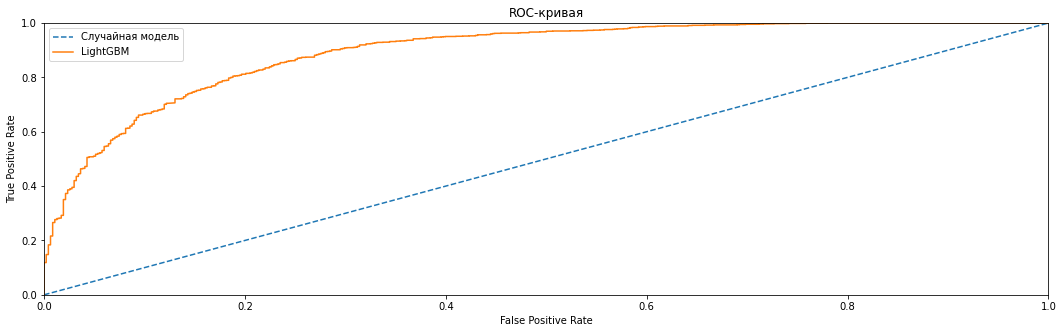

In [43]:
plt.figure() # построик roc-кривую

plt.figure(figsize=(18,5))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_lgb,tpr_lgb)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','LightGBM'),
           loc= 'upper left') 
plt.show()

На тестовой выборке auc-roc результат получился 0.89

## Вывод

При выполнении проекта был проведен исследовательский анализ данных, в котором мы выделели целевой признак, узнали что в датасете 1/4 абонентов ушла, а 3/4 осталась. Добавили новый целевой признак - кол-во дней в роли абонента. \
Во второй части проекта мы объединили все 4 таблицы, удалили лишних пользователей и обработали пропуски. После этого проанализировали корреляцию между признаками и целевым признаком. Сильной корреляции между признаками и целевым признаком не выявили, но больше всего связаны с ним - paymentMethod, monthlyCharges и loyalty. Следом закодировали все категоральные признаки.\
В третьей части обучили две модели: Случайный лес и LightGBM. При кросс-валидации из двух моделей лучший результат показала модель градиентного бустинга. \
В итоговой части мы использовали лучшую модель с тестовым набором и достигли результата auc-roc 0.89, а показатель accuracy - 0.84.

## Модифицированная модель 

Из анализа значимости корреляции признаков мы определили, что у некоторых признаков зависимость слабая, попробуем обучить модель без них и посмотрим результат. 

In [53]:
signif_params_list = ['gender', 'Dependents', 'PaperlessBilling', 'Partner', 'SeniorCitizen']

In [54]:
datax = data.copy()
datax = datax.drop(labels=signif_params_list, axis=1)

In [55]:
datax

,Type,PaymentMethod,MonthlyCharges,TotalCharges,still_here,loyalty,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,Month-to-month,Electronic check,29.85,29.85,1.00,31.00,DSL,No,Yes,No,No,No,No,no info
1,One year,Mailed check,56.95,"1,889.50",1.00,"1,036.00",DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Mailed check,53.85,108.15,0.00,61.00,DSL,Yes,Yes,No,No,No,No,No
3,One year,Bank transfer (automatic),42.30,"1,840.75",1.00,"1,371.00",DSL,Yes,No,Yes,Yes,No,No,no info
4,Month-to-month,Electronic check,70.70,151.65,0.00,61.00,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,Mailed check,84.80,"1,990.50",1.00,730.00,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,One year,Credit card (automatic),103.20,"7,362.90",1.00,"2,191.00",Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,Month-to-month,Electronic check,29.60,346.45,1.00,337.00,DSL,Yes,No,No,No,No,No,no info
7041,Month-to-month,Mailed check,74.40,306.60,0.00,123.00,Fiber optic,No,No,No,No,No,No,Yes


In [56]:
datax_train, datax_test = train_test_split(datax, 
                                         test_size=0.25, 
                                         random_state=171022)
features_train = datax_train.drop(['still_here'], axis=1)
target_train = datax_train['still_here']
features_test = datax_test.drop(['still_here'], axis=1)
target_test = datax_test['still_here']
print(features_train.shape, features_test.shape)

(5274, 13) (1758, 13)


In [59]:
categorical_columns = ['Type', 'PaymentMethod', 
                       'InternetService', 'OnlineSecurity','OnlineBackup', 
                       'DeviceProtection', 'TechSupport', 'StreamingTV',
                       'StreamingMovies', 'MultipleLines']

In [60]:
enc = OrdinalEncoder()
enc.fit(features_train[categorical_columns])

OrdinalEncoder()

In [61]:
features_train[categorical_columns] = enc.transform(features_train[categorical_columns])
features_test[categorical_columns] = enc.transform(features_test[categorical_columns])

In [63]:
%%time
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 150)]
num_leaves = [int(x) for x in np.linspace(start = 1, stop = 40)]
lgb_grid = {'n_estimators': n_estimators,
           'num_leaves':num_leaves}
lgb_rs_model = RandomizedSearchCV(estimator = lgb.LGBMClassifier(random_state=171022, class_weight='balanced'),
                                  param_distributions = lgb_grid, cv = 5, scoring = 'roc_auc')
lgb_rs_model.fit(features_train, target_train)

CPU times: user 53 s, sys: 462 ms, total: 53.5 s
Wall time: 54 s


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=171022),
                   param_distributions={'n_estimators': [100, 101, 102, 103,
                                                         104, 105, 106, 107,
                                                         108, 109, 110, 111,
                                                         112, 113, 114, 115,
                                                         116, 117, 118, 119,
                                                         120, 121, 122, 123,
                                                         124, 125, 126, 127,
                                                         128, 129, ...],
                                        'num_leaves': [1, 1, 2, 3, 4, 4, 5, 6,
                                                       7, 8, 8, 9, 10, 11, 12,
                                                       12, 13, 14, 15,

In [64]:
lgb_rs_model.best_params_

{'num_leaves': 34, 'n_estimators': 124}

In [65]:
lgb_rs_model.best_score_

0.8946346589401122

In [66]:
probabilities_lgb=lgb_rs_model.predict_proba(features_test) 
probabilities_one_lgb=probabilities_lgb[:,1]
fpr_lgb,tpr_lgb,thresholds=roc_curve(target_test,probabilities_one_lgb)

In [67]:
auc_roc_lgb = roc_auc_score(target_test, probabilities_one_lgb) #рассчет площади

In [71]:
auc_roc_lgb # На тестовой выборке рехультат 

0.9012812230835487

In [70]:
pred_lgb = lgb_rs_model.predict(features_test) 
accuracy_score(target_test, pred_lgb) # На тестовой выборке рехультат 

0.8378839590443686

## Отчет по проекту


При выполнения проекта в начале был поставлен план, из которого получилось выполнить все пункты. 

В первой главе сперва посмотрели все датасеты, увидели, что недостает целевого признака, а так же даты не подходили нам в роли признаков для обучения модели, поэтому вывели категоральный целевой признак still_here, который показывает остался абонент или нет. Опредилили его по тому, прерывалось ли действие договора или нет. Потом добавили вместо даты другой признак - loyalty - сколько дней человек является абонентом компании. Затем изучили распределние нового признака и осмотрели баланс между целевым признаком. Так же обнаружились пропуски в столбце TotalCharges, но так как их было мало, мы их удалили. 

Во второй главе объединили все таблицы в одну, нашли аномалии (их тоже было мало, удалили), появились прпоуски. Так как много прпоусков появилось у столбцов с услугами(['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']), то у них заменили пропуски уже имеющейся категорией No. Оставшиеся несколько столбцов добавили новую категорию no info. Удалили признак с датой. Далее провели анализ корреляции признаков и значимости корреляции. Так как никогда не пользовался инструментом philk, пришлось научиться использовать строить heatmap с помощью него и анализировать категоральные и числовые признаки вместе. После этого поделили выборки на тренировочную и тестовую 75:25 и закодировали категоральные признаки с помощью OrdinalEncoder.

В третьей главе обучили две модели: Случайный лес и LightGBM, признаки подбирали с помощью RandomizerSearchCV. При кросс-валидации из двух моделей лучший результат показала модель градиентного бустинга. Сперва планировалось использовать Catboost, но так как механизм подбора признаков у него другой, не получилось достигнуть хорошего результата, а модель LightGBM дала лучшие результаты и имплементация не сильно отличалась от случайного леса. 
В итоговой главе мы использовали лучшую модель с тестовым набором и достигли результата auc-roc 0.89, а показатель accuracy - 0.84. Так же была построена кривая AUC-ROC.

В плане все пункты были ключевыми и без них не получилось бы дстигнуть данных результатов. Я не испытал особых трудностей в проекте. 

Список признаков для обучения модели: Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, loyalty, gender, SeniorCitizen, Partner, Dependents, InternetService, OnlineSecurity, OnlineBackup, DeviceProtectio, TechSupport, StreamingTV, StreamingMovies, MultipleLines.\
Целевой признак -  still_here\
Итоговая модель - LightGBM с гиперпараметрами num_leaves: 36, n_estimators: 128
